In [1]:
import random
import numpy as np
import statistics 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from scipy import ndimage
from scipy import stats
from scipy.spatial import distance
from scipy.stats.stats import pearsonr 
import scipy.signal 
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

from sklearn import preprocessing
from itertools import cycle
import seaborn as sns
import math


#plotting params
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = '0.5'
mpl.rcParams['axes.labelsize'] = '8'
mpl.rcParams['axes.labelcolor'] = 'black'

mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['xtick.labelsize'] = '8'
mpl.rcParams['ytick.labelsize'] = '8'
mpl.rcParams['ytick.color'] = 'black'

In [21]:
#Mask - defining surrogate behavioral vector
num_frames = 12000
behav_every = 100
behav_time = 10

mask = np.zeros(num_frames)
for i in range(len(mask)):
    if i > 0 and i % (behav_every*20) == 0:
        mask[i:i+(behav_time*20)] = 1

In [61]:
#Input the surrogate data type
data_type = 'random'
#---------------------------------------------------------------------------
if data_type == 'synchronous':
    #Defining synchronous surrogate data
    print('surrogate data = synchronous')
    num_neurons = 200
    event_every = behav_every
    event_scaler = 5

    events_matrix = np.ones(num_frames)
    for i in range(len(events_matrix)):
        if i > 0 and i % (event_every*20) == 0:
            events_matrix[i:i+(behav_time*20)] = event_scaler

    seed = random.seed(num_frames)
    surrogate = []
    for i in range(num_neurons):
        sigma = 2
        surrogate.append(ndimage.gaussian_filter1d(np.random.rand(num_frames)*events_matrix, sigma))

elif data_type == 'asynchronous':
    #Defining asynchronous surrogate data
    print('surrogate data = asynchronous')
    num_neurons = 200
    event_every = behav_every
    event_scaler = 5

    events_matrix = np.ones(num_frames)
    events_matrix = events_matrix * event_scaler
    for i in range(len(events_matrix)):
        if i % (event_every*20) == 0:
            events_matrix[i:i+(behav_time*20)] = 1
            

    seed = random.seed(num_frames)
    surrogate = []
    for i in range(num_neurons):
        sigma = 2
        surrogate.append(ndimage.gaussian_filter1d(np.random.rand(num_frames)*events_matrix, sigma))

elif data_type == 'random':
    #Defining random surrogate data
    print('surrogate data = random')
    num_neurons = 200
    event_every = behav_every
    event_scaler = 5

    events_matrix = np.ones(num_frames)
    random_events = sorted([random.randint(0, num_frames) for i in range(int((num_frames/20)/30))])
    for i in range(len(events_matrix)):
        for j in random_events:
            if j == i:
                events_matrix[j:j+(behav_time*20)] = event_scaler

    seed = random.seed(num_frames)
    surrogate = []
    for i in range(num_neurons):
        sigma = 2
        surrogate.append(ndimage.gaussian_filter1d(np.random.rand(num_frames)*events_matrix, sigma))
        


surrogate data = random


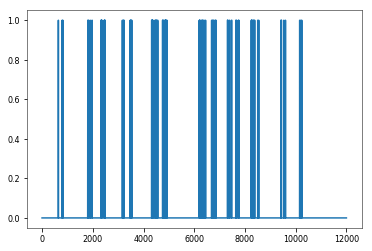

In [62]:
# plt.plot(surrogate[0])
new_surrogate = []
for neuron in surrogate:
    neuron_new = []
    for sample in neuron:
        if sample > 3.2:
            neuron_new.append(1)
        else:
            neuron_new.append(0)
    new_surrogate.append(neuron_new)

plt.plot(new_surrogate[1])
surrogate = new_surrogate

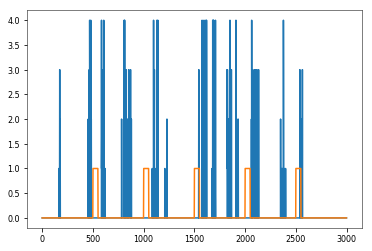

In [63]:
surrogate_events_all = []
for neuron in surrogate:
    surrogate_events = []
    for sample in range(len(neuron)):
        if neuron[sample] > 1:
            surrogate_events.append(1)
        else:
            surrogate_events.append(0)
    surrogate_events_all.append(surrogate_events)
        
def event_categorization(event_trace, bin_size = 0.25):
    """"Categorize all event traces into different bins of spike amplitudes.
    Due to low resolution, we can account for any lost spikes and weight events accordingly"""
    bin_size = bin_size #<---- must be greater than 0.25
    all_events = []
    data_events_categorised = []
    for neuron in range(len(event_trace)):
        neuron_events_categorised = []
        for event in event_trace[neuron]:
            if event > 0:
                if event < bin_size:
                    neuron_events_categorised.append(1)
                elif bin_size < event < (bin_size*2):
                    neuron_events_categorised.append(1)
                elif (bin_size*2) < event < (bin_size*3):
                    neuron_events_categorised.append(1)
                elif (bin_size*3) < event :
                    neuron_events_categorised.append(1)
            else:
                neuron_events_categorised.append(0)         
        data_events_categorised.append(neuron_events_categorised)
    return data_events_categorised

def spike_binning(spike_array, bin_size=4):
    bin_size = bin_size
    binned_spikes = []
    for neuron in spike_array:
        per_neuron=[]
        i=0
        while i <= len(neuron):
            per_neuron.append(sum(neuron[i:i+bin_size]))
            i+=bin_size
        binned_spikes.append(per_neuron)
    return binned_spikes

def behav_vector_binning(behav_vector, bin_size=4):
    bin_size = bin_size
    binned_behav_vector = []
    i=0
    while i <= len(behav_vector):
        binned_behav_vector.append(stats.mode(behav_vector[i:i+bin_size])[0])
        i+=bin_size
    return binned_behav_vector

binned_data_events_categorised = np.array(spike_binning(surrogate))
binned_behav_vector = np.array(behav_vector_binning(mask)).tolist()
binned_behav_vector = np.array([item for sublist in binned_behav_vector for item in sublist])

plt.plot(binned_data_events_categorised[0])
plt.plot(binned_behav_vector)

In [64]:
def mutualinfo_cell_stim(binned_behav_vector, binned_data_events_categorised):
    """CELL STIMULUS MUTUAL INFORMATION calculated using behavioual vector
    and the binned data events"""
    #Probability of each behaviour occuring
    count_dic = {}
    for behaviour in binned_behav_vector:
        #Number of spikes of different amplitude during different behaviours
        count_entry = str(int(behaviour))
        if count_entry in count_dic:
            count_dic[count_entry] += 1
        else:
            count_dic[count_entry] = 1  
    probability_dic ={}
    for key in count_dic:
        probability_dic[key] = count_dic[key]/sum(count_dic.values())
    print(probability_dic)
    mi_r_cat = []
    probability_dic_all = {}
    for neuron in range(len(binned_data_events_categorised)): 
        #Define probability of each neuron firing
        count_individ_dic = {0:0, 1:0}
        for spike in binned_data_events_categorised[neuron]:
            spike_count_entry = int(spike)
            if spike_count_entry > 0:
                count_individ_dic[1] += spike*1
            else:
                count_individ_dic[0] += 1 

        probability_response_dic = {}
        for key in count_individ_dic:
            probability_response_dic[key] = count_individ_dic[key]/sum(count_dic.values())

        #define entropy for every neuron
        entropyr = 0
        for key in probability_response_dic:
            entropyr += -(probability_response_dic[key]*math.log2(probability_response_dic[key]))
        
        #intialise count__spike_behav_dic
        count__spike_behav_dic = {}
        for key in count_dic:
            count__spike_behav_dic['0'+key]=0
            count__spike_behav_dic['1'+key]=0    

        #How many spikes are there during each behaviour
        for spike, behaviour in zip(binned_data_events_categorised[neuron], binned_behav_vector):
            count_entry = str(int(spike))+str(int(behaviour))
            if int(count_entry[0]) > 0:
                count_entry = str(1)+str(int(behaviour))
                count__spike_behav_dic[count_entry] += spike*1
            else:
                count__spike_behav_dic[count_entry] += 1

        #What is the probability of that spike during the behaviour
        probability_spike_behav_dic = {}         
        for key in count__spike_behav_dic:
            probability_spike_behav_dic[key] = count__spike_behav_dic[key]/sum(count_dic.values())
        print(probability_spike_behav_dic)

        cond_ent =0
        for key in probability_spike_behav_dic:
            if  probability_spike_behav_dic[key] > 0:
                cond_ent += probability_spike_behav_dic[key]*math.log2(probability_dic[key[1]]/probability_spike_behav_dic[key])

        mi_resbehav = entropyr - cond_ent
        mi_r_cat.append(mi_resbehav)

    total_categorised_info = sum(mi_r_cat)
    return mi_r_cat

if data_type == 'synchronous':
    sync_mi_r_cat = mutualinfo_cell_stim(binned_behav_vector, binned_data_events_categorised)

elif data_type == 'asynchronous':
    async_mi_r_cat = mutualinfo_cell_stim(binned_behav_vector, binned_data_events_categorised)

elif data_type == 'random':
    rand_mi_r_cat = mutualinfo_cell_stim(binned_behav_vector, binned_data_events_categorised)



{'0': 0.9166666666666666, '1': 0.08333333333333333}
{'00': 0.8733333333333333, '10': 0.09033333333333333, '01': 0.08166666666666667, '11': 0.0036666666666666666}
{'00': 0.8723333333333333, '10': 0.098, '01': 0.08266666666666667, '11': 0.0016666666666666668}
{'00': 0.8723333333333333, '10': 0.10766666666666666, '01': 0.08166666666666667, '11': 0.0036666666666666666}
{'00': 0.8743333333333333, '10': 0.10066666666666667, '01': 0.082, '11': 0.0023333333333333335}
{'00': 0.8766666666666667, '10': 0.094, '01': 0.08233333333333333, '11': 0.002}
{'00': 0.8786666666666667, '10': 0.08666666666666667, '01': 0.08066666666666666, '11': 0.005333333333333333}
{'00': 0.8673333333333333, '10': 0.114, '01': 0.08166666666666667, '11': 0.004666666666666667}
{'00': 0.8676666666666667, '10': 0.11166666666666666, '01': 0.08133333333333333, '11': 0.006333333333333333}
{'00': 0.8746666666666667, '10': 0.09833333333333333, '01': 0.07966666666666666, '11': 0.008333333333333333}
{'00': 0.8726666666666667, '10': 0

{'00': 0.8676666666666667, '10': 0.116, '01': 0.08133333333333333, '11': 0.005}
{'00': 0.8716666666666667, '10': 0.099, '01': 0.08333333333333333, '11': 0.0}
{'00': 0.8693333333333333, '10': 0.10666666666666667, '01': 0.081, '11': 0.005}
{'00': 0.8793333333333333, '10': 0.087, '01': 0.078, '11': 0.012333333333333333}
{'00': 0.8696666666666667, '10': 0.109, '01': 0.082, '11': 0.0033333333333333335}
{'00': 0.8676666666666667, '10': 0.11, '01': 0.08033333333333334, '11': 0.007}
{'00': 0.8746666666666667, '10': 0.09466666666666666, '01': 0.082, '11': 0.003}
{'00': 0.8683333333333333, '10': 0.11266666666666666, '01': 0.08233333333333333, '11': 0.002}
{'00': 0.8736666666666667, '10': 0.098, '01': 0.081, '11': 0.0036666666666666666}
{'00': 0.879, '10': 0.08566666666666667, '01': 0.08133333333333333, '11': 0.005333333333333333}
{'00': 0.8783333333333333, '10': 0.09566666666666666, '01': 0.08066666666666666, '11': 0.005333333333333333}
{'00': 0.879, '10': 0.08066666666666666, '01': 0.0813333333

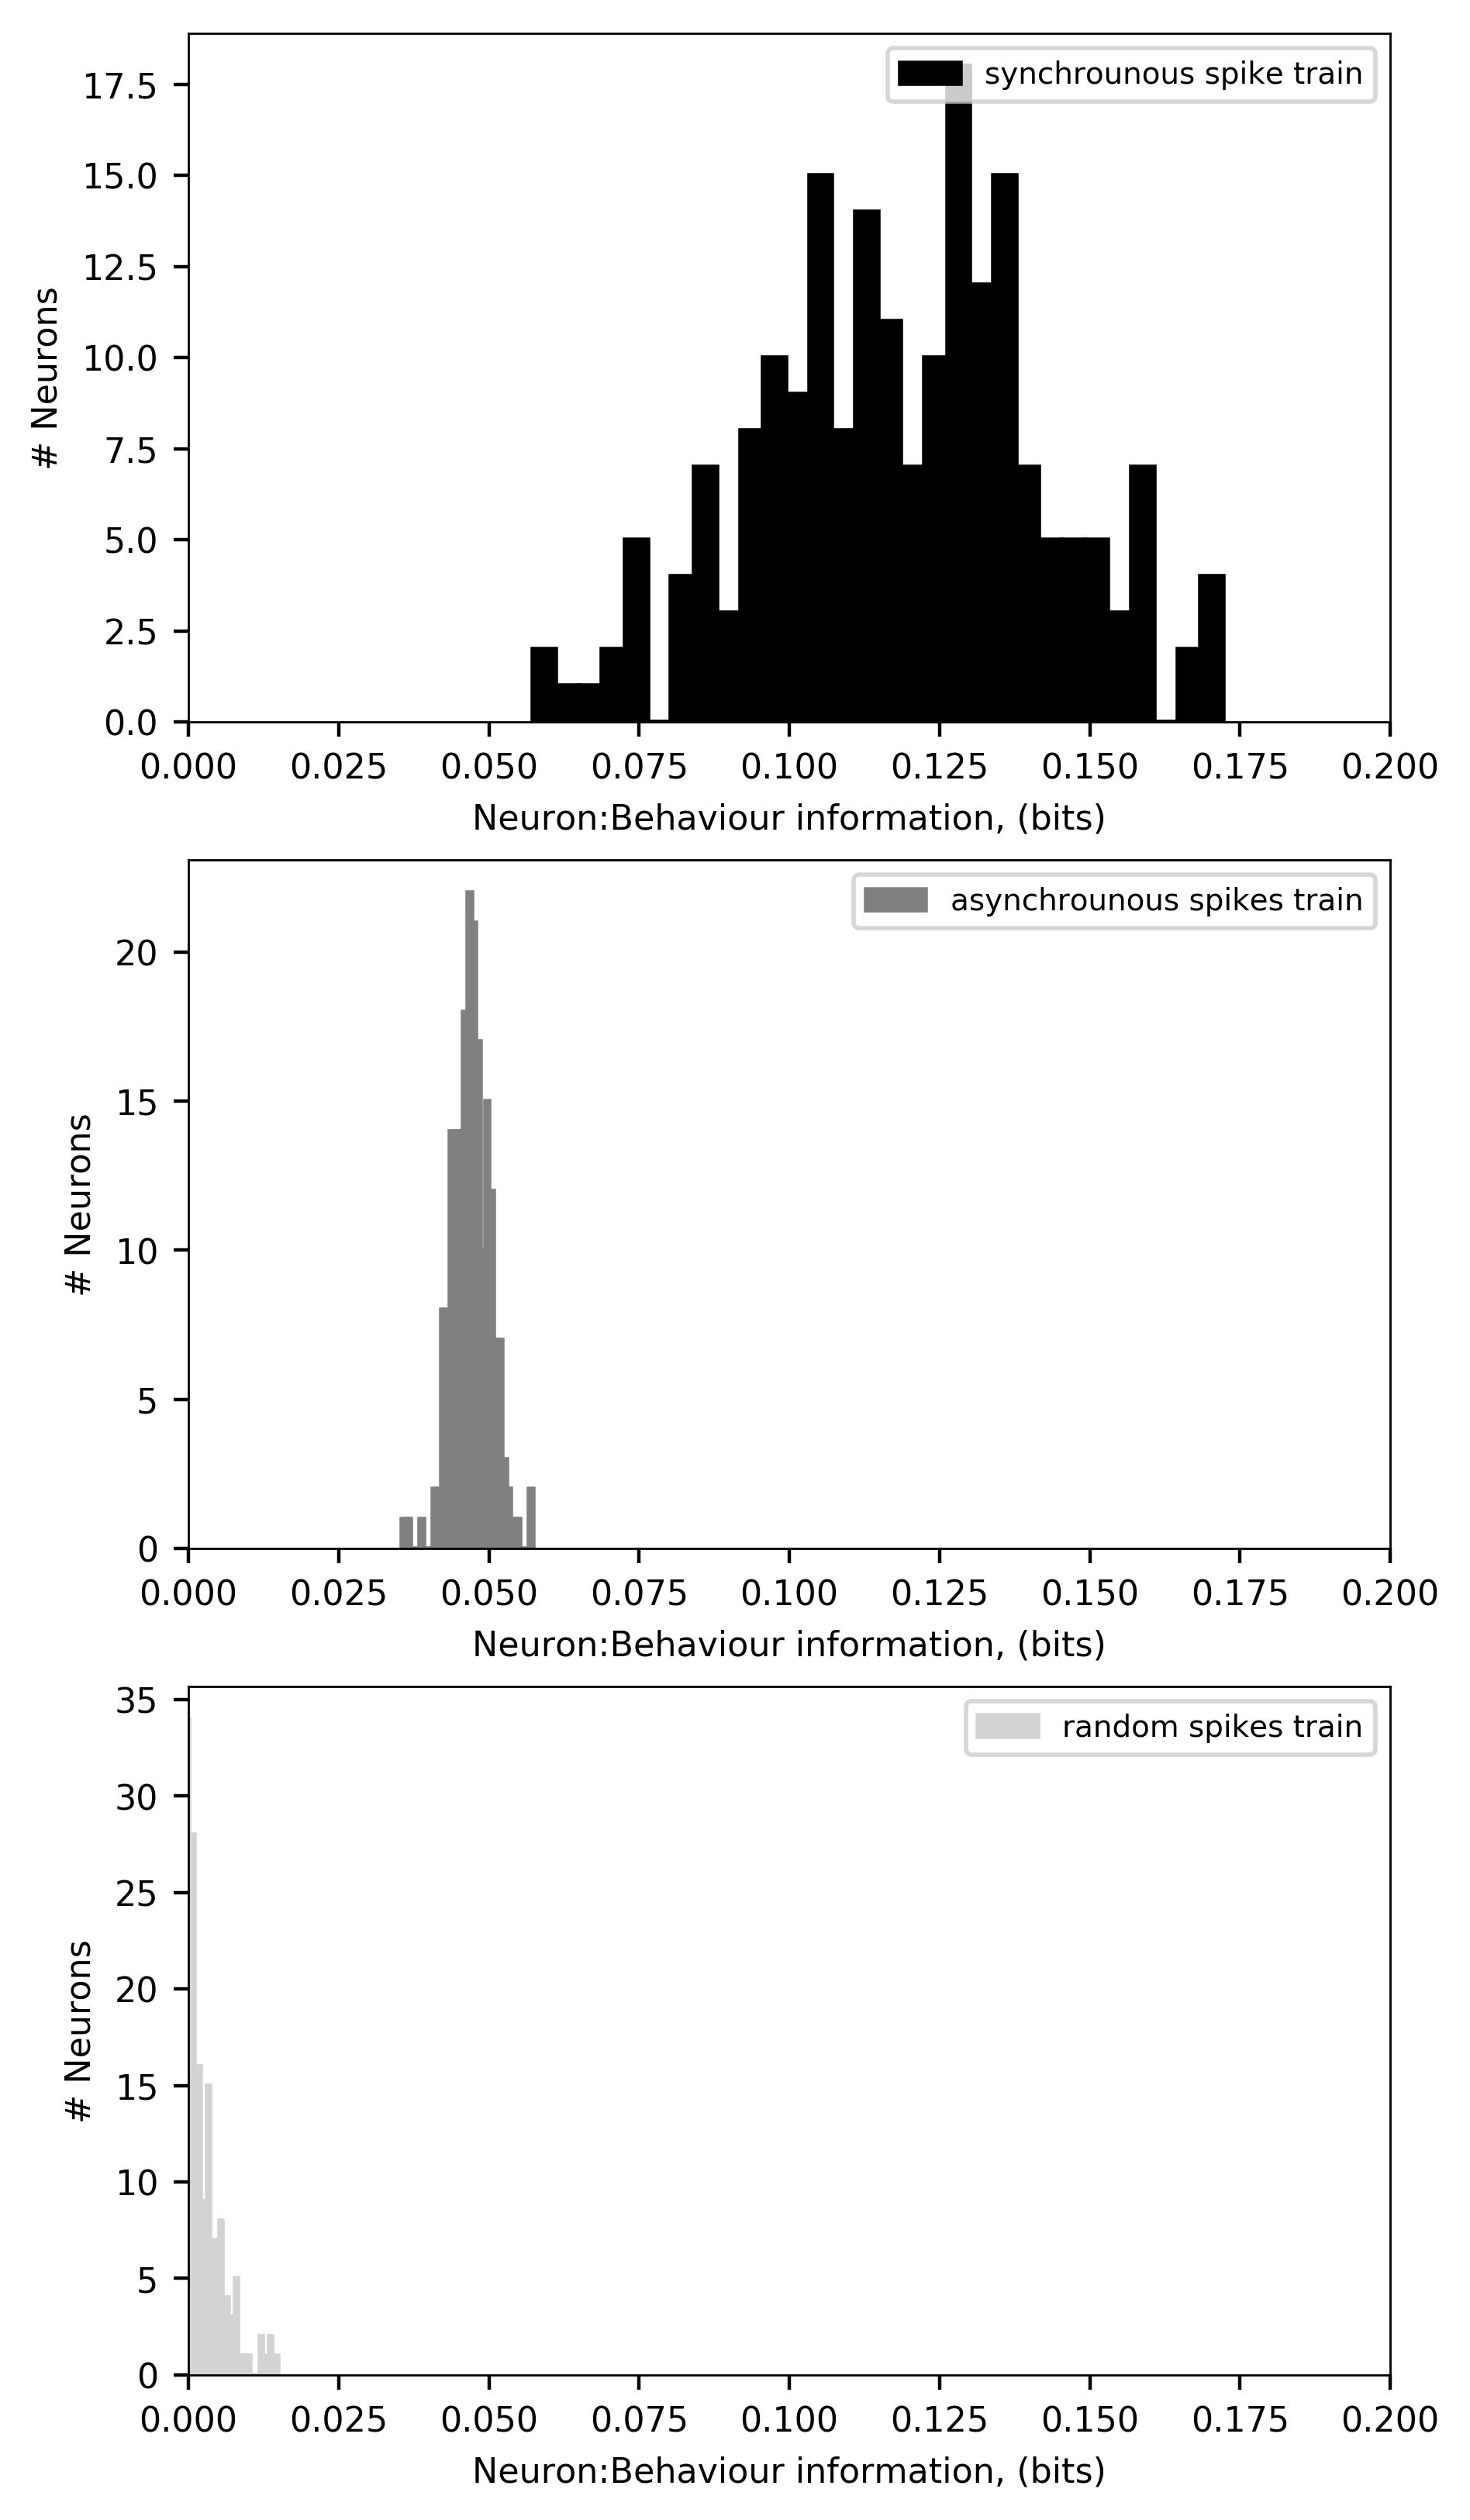

In [66]:
fig, axs = plt.subplots(3, 1, figsize=(5, 10), dpi=400)
gs = gridspec.GridSpec(3, 1, height_ratios=[1,1,1]) 

labels= ["synchrounous spike train"]
axs[0] = plt.subplot(gs[0])
axs[0] = plt.hist(sync_mi_r_cat, bins=30, color = 'k', edgecolor='k')
axs[0] = plt.legend(labels, loc=1, prop={'size': 7})
axs[0] = plt.xlabel("Neuron:Behaviour information, (bits)")
axs[0] = plt.ylabel("# Neurons")
axs[0] = plt.xlim(0,0.2)


axs[1] = plt.subplot(gs[1])
axs[1] = plt.hist(async_mi_r_cat, bins=30, color = 'gray', edgecolor='gray')
labels= ["asynchrounous spikes train"]
axs[1] = plt.legend(labels, loc=1, prop={'size': 7})
axs[1] = plt.xlabel("Neuron:Behaviour information, (bits)")
axs[1] = plt.ylabel("# Neurons")
axs[1] = plt.xlim(0,0.2)

axs[2] = plt.subplot(gs[2])
axs[2] = plt.hist(rand_mi_r_cat, bins=30, color = 'lightgray', edgecolor='lightgray')
labels= ["random spikes train"]
axs[2] = plt.legend(labels, loc=1, prop={'size': 7})
axs[2] = plt.xlabel("Neuron:Behaviour information, (bits)")
axs[2] = plt.ylabel("# Neurons")
axs[2] = plt.xlim(0,0.2)
plt.show()

(-0.01, 0.2)

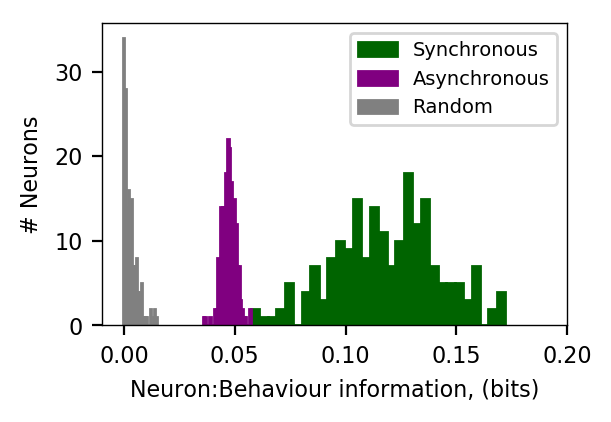

In [78]:
plt.figure(figsize=(3, 2), dpi=200)

labels = ['Synchronous', 'Asynchronous','Random']
plt.hist(sync_mi_r_cat, bins=30, color = 'darkgreen', edgecolor='darkgreen')
plt.hist(async_mi_r_cat, bins=30, color = 'purple', edgecolor='purple')
plt.hist(rand_mi_r_cat, bins=30, color = 'gray', edgecolor='gray')
plt.legend(labels, loc=1, prop={'size': 7})
plt.xlabel("Neuron:Behaviour information, (bits)")
plt.ylabel("# Neurons")
plt.xlim(-0.01,0.2)


TypeError: Invalid dimensions for image data

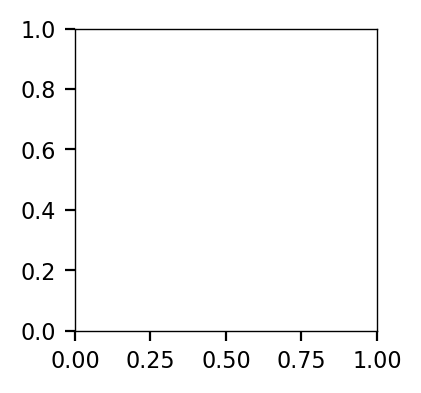

In [87]:
plt.figure(figsize=(3, 2), dpi=200)

plt.imshow(sync_mi_r_cat[1], cmap="coolwarm")
plt.title("Neuron Pairwise MI")
plt.yticks(rotation=0)
plt.colorbar(shrink=0.5)

